In [19]:
import os
import shutil
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import time
from torchvision import transforms
from PIL import Image
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from datetime import datetime

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
df = pd.read_csv("dataset_columns.csv")
df = df[['Image Index', 'Finding Labels']].dropna()
df['Image Index'] = df['Image Index'].str.strip().str.lower()
df['Finding Labels'] = df['Finding Labels'].str.strip()

unique_conditions = set()
for entry in df['Finding Labels']:
    labels = entry.split('|')
    unique_conditions.update(labels)

unique_conditions = sorted(list(unique_conditions))
condition_to_index = {cond: idx for idx, cond in enumerate(unique_conditions)}
index_to_condition = {idx: cond for cond, idx in condition_to_index.items()}
num_conditions = len(unique_conditions)

def encode_multilabel(label_str):
    label_vector = [0] * num_conditions
    for condition in label_str.split('|'):
        if condition in condition_to_index:
            label_vector[condition_to_index[condition]] = 1
            
    return label_vector

df['encoded'] = df['Finding Labels'].apply(encode_multilabel)
df[['Image Index', 'Finding Labels', 'encoded']].head()

image_labels = dict(zip(df['Image Index'], df['Finding Labels']))
image_dir = 'merged_images'
output_dir = 'split_dataset'

os.makedirs(os.path.join(output_dir, 'train'), exist_ok = True)
os.makedirs(os.path.join(output_dir, 'val'), exist_ok = True)
os.makedirs(os.path.join(output_dir, 'test'), exist_ok = True)

all_images = [f for f in os.listdir(image_dir) if f.endswith('.png')]
print(f"Found {len(all_images)} images in directory")

matched_images = []
matched_labels = []
missing_count = 0

for img in all_images:
    key = img.strip().lower()
    if key in image_labels:
        matched_images.append(img)
        matched_labels.append(image_labels[key])
    else:
        missing_count += 1
print(f"Matched {len(matched_images)} images with labels")
print(f"{missing_count} images had no matching label")

if len(matched_images) == 0:
    raise ValueError("No images matched with labels in image_labels dictionary")

X_train, X_temporary, y_train, y_temporary = train_test_split(matched_images, matched_labels, test_size = 0.3, random_state = 42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temporary, y_temporary, test_size = 0.5, random_state = 42)

def process_dataset(images, labels, subset):
    subset_dir = os.path.join(output_dir, subset)
    label_file = os.path.join(output_dir, f'{subset}_labels.txt')

    for img in images:
        src = os.path.join(image_dir, img)
        dst = os.path.join(subset_dir, img)
        shutil.copyfile(src, dst)

    with open(label_file, 'w') as f:
        for img, label in zip(images, labels):
            f.write(f"{img} {label}\n")

process_dataset(X_train, y_train, 'train')
process_dataset(X_validation, y_validation, 'val')
process_dataset(X_test, y_test, 'test')

print("\nDataset splitting complete!")
print(f"Train: {len(X_train)} images")
print(f"Validation: {len(X_validation)} images")
print(f"Test: {len(X_test)} images")
print(f"Total matched: {len(matched_images)} images")
print(f"Total unmatched: {missing_count} images")


Found 60990 images in directory
Matched 60990 images with labels
0 images had no matching label

Dataset splitting complete!
Train: 42693 images
Validation: 9148 images
Test: 9149 images
Total matched: 60990 images
Total unmatched: 0 images


In [ ]:
class VGG(nn.Module):

    def __init__(self, num_classes: int):
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size = 3, padding = 1, bias = False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace = True),
                nn.Conv2d(out_c, out_c, kernel_size = 3, padding = 1, bias = False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace = True),
                nn.MaxPool2d(kernel_size = 2, stride = 2)
            )

        self.features = nn.Sequential(
            conv_block(1,  32),
            conv_block(32, 64),
            conv_block(64, 128),
            conv_block(128, 256)
        )

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p = 0.4),
            nn.Linear(256, 128),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x


In [21]:
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss, correct_imgs, total_imgs = 0.0, 0, 0
    all_predictions, all_targets = [], []

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicts = (torch.sigmoid(logits) > 0.5).float()
        correct_imgs += (predicts == labels).all(dim = 1).sum().item()
        total_imgs += labels.size(0)

        all_predictions.append(predicts.cpu())
        all_targets.append(labels.cpu())

    y_prediction = torch.cat(all_predictions).numpy()
    y_true = torch.cat(all_targets).numpy()

    return (        
        running_loss / len(dataloader),
        100.0 * correct_imgs / total_imgs,
        precision_score(y_true, y_prediction, average = 'macro', zero_division = 0),
        recall_score(y_true, y_prediction, average = 'macro', zero_division = 0),
        f1_score(y_true, y_prediction, average = 'macro', zero_division = 0)
    )




In [22]:
COLLECT_ROC = True
validation_logits, validation_targets = [], []

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct_imgs, total_imgs = 0.0, 0, 0
    all_predictions, all_targets, all_logits = [], [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            logits = model(images)
            loss = criterion(logits, labels)
            running_loss += loss.item()

            preds = (torch.sigmoid(logits) > 0.5).float()
            correct_imgs += (preds == labels).all(dim=1).sum().item()
            total_imgs += labels.size(0)

            all_predictions.append(preds.cpu())
            all_targets.append(labels.cpu())

            if COLLECT_ROC:
                all_logits.append(logits.cpu())

    y_prediction = torch.cat(all_predictions).numpy()
    y_true = torch.cat(all_targets).numpy()

    if COLLECT_ROC:
        validation_logits.append(torch.cat(all_logits))
        validation_targets.append(torch.from_numpy(y_true))

    return (
        running_loss / len(dataloader),
        100.0 * correct_imgs / total_imgs,
        precision_score(y_true, y_prediction, average = 'macro', zero_division = 0),
        recall_score(y_true, y_prediction, average = 'macro', zero_division = 0),
        f1_score(y_true, y_prediction, average = 'macro', zero_division = 0)
    )

In [23]:
print(f"{device} for training and testing")

all_conditions = set()

for labels in image_labels.values():
    all_conditions.update(labels.split('|'))

all_conditions = sorted(list(all_conditions))
condition_to_index = {cond: idx for idx, cond in enumerate(all_conditions)}
index_to_condition = {idx: cond for cond, idx in condition_to_index.items()}
num_classes = len(all_conditions)

print("The number of classes", num_classes)
print("Sample class indices:", condition_to_index)

def encode_multilabel(label_str):
    label_vector = [0] * num_classes

    for cond in label_str.split('|'):
        if cond in condition_to_index:
            label_vector[condition_to_index[cond]] = 1

    return label_vector

y_train = [encode_multilabel(image_labels[img]) for img in X_train]
y_validation = [encode_multilabel(image_labels[img]) for img in X_validation]
y_test = [encode_multilabel(image_labels[img]) for img in X_test]

class LabeledImageDataset(Dataset):
    def __init__(self, image_filenames, labels, image_dir, transform = None):
        self.image_filenames = image_filenames
        self.labels = labels
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        label = torch.tensor(self.labels[idx], dtype = torch.float32)
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = LabeledImageDataset(X_train, y_train, 'split_dataset/train', transform)
validation_dataset = LabeledImageDataset(X_validation, y_validation, 'split_dataset/val', transform)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers = 0)
validation_loader = DataLoader(validation_dataset, batch_size = 32, shuffle = False, num_workers = 0)
img, label = train_dataset[0]
model = VGG(num_classes = num_classes)
model = model.to(device)

with torch.no_grad():
    dummy = torch.randn(1, 1, 224, 224).to(device)
    out = model(dummy)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
num_epochs = 10
train_losses, validation_losses = [], []
train_accuracies, validation_accuracies = [], []
train_f1s, validation_f1s = [], []

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_accuracy, train_precision, train_recall, train_f1 = train_model(model, train_loader, optimizer, criterion, device)
    validation_loss, validation_accuracy, validation_precision, validation_recall, validation_f1 = evaluate_model(model, validation_loader, criterion, device)

    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)
    train_f1s.append(train_f1)
    validation_f1s.append(validation_f1)

    elapsed = time.time() - start_time
    eta = elapsed * (num_epochs - epoch - 1)

    print(f"\nEpoch {epoch + 1} of {num_epochs}  Time: {elapsed:.2f}s  ETA: {eta / 60:.1f} min")
    print(f"Train loss: {train_loss:.2f} | Accuracy: {train_accuracy:.2f}% | Precision: {train_precision:.2f} | Recall: {train_recall:.2f} | F1: {train_f1:.2f}")
    print(f"Validation loss: {validation_loss:.2f} | Accuracy: {validation_accuracy:.2f}% | Precision: {validation_precision:.2f} | Recall: {validation_recall:.2f} | F1: {validation_f1:.2f}")


mps for training and testing
The number of classes 6
Sample class indices: {'Atelectasis': 0, 'Effusion': 1, 'Infiltration': 2, 'Mass': 3, 'No Finding': 4, 'Nodule': 5}

Epoch 1 of 10  Time: 338.59s  ETA: 50.8 min
Train loss: 0.42 | Accuracy: 28.81% | Precision: 0.29 | Recall: 0.10 | F1: 0.10
Validation loss: 0.40 | Accuracy: 37.96% | Precision: 0.20 | Recall: 0.13 | F1: 0.12

Epoch 2 of 10  Time: 274.12s  ETA: 36.5 min
Train loss: 0.40 | Accuracy: 32.65% | Precision: 0.27 | Recall: 0.12 | F1: 0.13
Validation loss: 0.40 | Accuracy: 30.43% | Precision: 0.19 | Recall: 0.13 | F1: 0.15

Epoch 3 of 10  Time: 263.11s  ETA: 30.7 min
Train loss: 0.40 | Accuracy: 34.08% | Precision: 0.34 | Recall: 0.14 | F1: 0.15
Validation loss: 0.39 | Accuracy: 38.47% | Precision: 0.30 | Recall: 0.14 | F1: 0.15

Epoch 4 of 10  Time: 288.32s  ETA: 28.8 min
Train loss: 0.39 | Accuracy: 35.36% | Precision: 0.29 | Recall: 0.15 | F1: 0.17
Validation loss: 0.39 | Accuracy: 33.06% | Precision: 0.33 | Recall: 0.16 | 

In [24]:
torch.save(model.state_dict(), "vgg_model.pth")

In [26]:
test_dataset = LabeledImageDataset(X_test, y_test, 'split_dataset/test', transform)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False, num_workers = 0)
test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model, test_loader, criterion, device)

print("\nTest evaluation:")
print(f"Test — Loss: {test_loss:.2f} | Acc: {test_accuracy:.2f}% | Preision: {test_precision:.2f} | Rec: {test_recall:.2f} | F1: {test_f1:.2f}")



Test evaluation:
Test — Loss: 0.43 | Acc: 30.67% | Preision: 0.62 | Rec: 0.16 | F1: 0.19


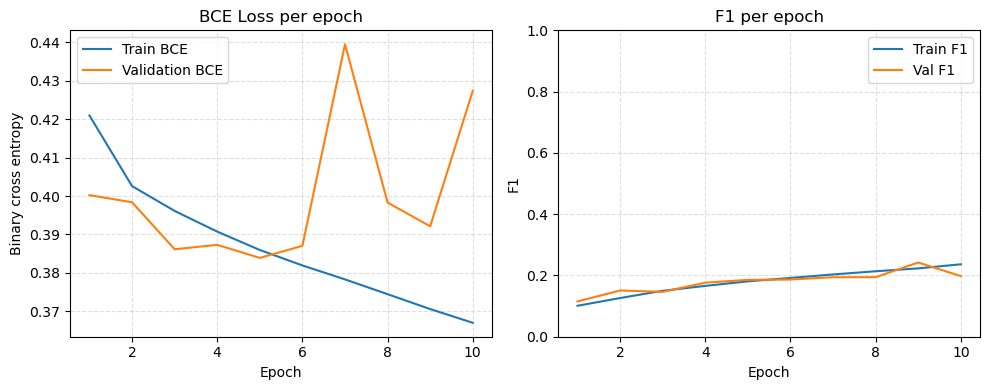

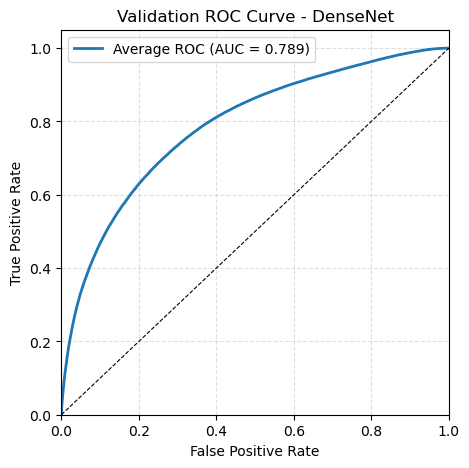

In [27]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize = (10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label = 'Train BCE')
plt.plot(epochs, validation_losses, label = 'Validation BCE')
plt.xlabel('Epoch')
plt.ylabel('Binary cross entropy')
plt.title('BCE Loss per epoch')
plt.legend()
plt.grid(True, ls='--', alpha=.4)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_f1s, label = 'Train F1')
plt.plot(epochs, validation_f1s, label = 'Val F1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.ylim(0, 1)
plt.title('F1 per epoch')
plt.legend()
plt.grid(True, ls='--', alpha=.4)

plt.tight_layout()
plt.show()

if COLLECT_ROC:
    logits = torch.cat(validation_logits)
    targets = torch.cat(validation_targets)
    probs = torch.sigmoid(logits).numpy()
    y_true = targets.numpy()
    fpr, tpr, _ = roc_curve(y_true.ravel(), probs.ravel())
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize = (5, 5))
    plt.plot(fpr, tpr, label=f"Average ROC (AUC = {roc_auc:.3f})", lw = 2)
    plt.plot([0, 1], [0, 1], 'k--', lw = .8)
    plt.xlim([0, 1]); plt.ylim([0, 1.05])
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("Validation ROC Curve - DenseNet")
    plt.legend(); plt.grid(ls='--', alpha=.4)
    plt.show()



In [ ]:
_val_logits, _val_targets = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        _val_logits.append(logits.cpu())
        _val_targets.append(labels.cpu())

logits = torch.cat(_val_logits).numpy()
targets = torch.cat(_val_targets).numpy()
n_classes = targets.shape[1]
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(targets[:, i], logits[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [29]:
preds = (logits > 0.5).astype(int)
f1_per_class = f1_score(targets, preds, average=None, zero_division=0)

plt.figure(figsize=(10, 6))
bars = plt.bar(all_conditions, f1_per_class, color ='skyblue')
plt.ylabel("F1 Score")
plt.xlabel("Condition")
plt.ylim(0, 1)
plt.title("F1 Score per Class")
plt.grid(axis='y')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

In [30]:
out_dir = Path("runs_vgg") / datetime.now().strftime("%Y%m%d_%H%M%S")
out_dir.mkdir(parents=True, exist_ok=True)

metrics = {
    "train_loss": train_losses,
    "val_loss": validation_losses,
    "train_acc": train_accuracies,
    "val_acc": validation_accuracies,
    "train_f1": train_f1s,
    "val_f1": validation_f1s,
}

min_len = min(len(v) for v in metrics.values())
metrics = {k: v[:min_len] for k, v in metrics.items()}
metrics["epoch"] = list(range(1, min_len + 1))
df = pd.DataFrame(metrics)
df = df[["epoch"] + [k for k in metrics if k != "epoch"]]

combined_csv = out_dir / "training_metrics.csv"
df.to_csv(combined_csv, index=False)
print(f"Saved {combined_csv}")

for name, series in metrics.items():
    if name != "epoch":
        pd.Series(series, name=name, index = pd.Index(range(1, len(series) + 1), name = "epoch")).to_csv(out_dir / f"{name}.csv")


print(f"Saved all files in {out_dir}")


Saved runs_vgg/20250504_003536/training_metrics.csv
Saved all files in runs_vgg/20250504_003536
